# Interpolación Espacial de Precipitación usando Gaussian Processes

Este documento explica el proceso de interpolación espacial de la precipitación utilizando Gaussian Processes, basado en la matriz de covarianza definida por Cowperwait (1991). Se utilizan `numba` y `joblib` para mejorar la eficiencia computacional.

## Conceptos Básicos

### Gaussian Processes (GP)
Los Gaussian Processes son modelos no paramétricos utilizados para la regresión y la interpolación de datos. Un GP define una distribución sobre funciones y se utiliza para predecir valores en puntos no observados utilizando una función de covarianza que describe la relación entre los puntos observados y no observados.

### Matriz de Covarianza de Cowperwait (1991)
La matriz de covarianza en Gaussian Processes define cómo los valores en diferentes ubicaciones se correlacionan entre sí. La implementación de Cowperwait (1991) utiliza un modelo de proceso puntual agrupado de Neyman-Scott para modelar la precipitación. La covarianza se calcula usando una fórmula específica que incorpora varios parámetros.

## Formulaciones Matemáticas

### Función `E_X`
La función \(E_X\) calcula el valor esperado de \(X^p\):

$$
E_X(\xi, \alpha, p) = \xi^p \cdot \alpha^p
$$

### Función de Covarianza `NSRP_covariance`
La función de covarianza basada en el modelo de Cowperwait (1991) se define como:

$$
\text{NSRP\_covariance}(h, l, \lambda, \mu_c, \eta, \xi, \beta, \alpha, \alpha_p) = \sum_{i=1}^{n} \left( \text{term1} - \text{term2} \right) 
$$

Para \( l = 0 \):

$$
A = \eta \cdot h - 1 + \exp(-\eta \cdot h)
$$

$$
B = \beta \cdot h - 1 + \exp(-\beta \cdot h)
$$

Para \( l > 0 \):

$$
A = 0.5 \left( (1 - \exp(-\eta \cdot h))^2 \right) \cdot \exp(-\eta \cdot h \cdot (l - 1))
$$

$$
B = 0.5 \left( (1 - \exp(-\beta \cdot h))^2 \right) \cdot \exp(-\beta \cdot h \cdot (l - 1))
$$

Términos:

$$
\text{term1} = \alpha_p \cdot \left( \lambda \cdot \eta^{-3} \cdot A \cdot \left( 2 \cdot \mu_c \cdot E_X\left( \frac{1}{\xi}, \alpha, 2 \right) + \left( E_X\left( \frac{1}{\xi}, \alpha, 1 \right)^2 \right) \cdot \beta^2 \cdot \frac{\mu_c^2}{\beta^2 - \eta^2} \right) \right)
$$

$$
\text{term2} = \lambda \cdot \left( E_X\left( \frac{1}{\xi}, \alpha, 1 \right)^2 \right) \cdot B \cdot \frac{\mu_c^2}{\beta \cdot (\beta^2 - \eta^2)}
$$

$$
\text{NSRP\_covariance}(h, l, \lambda, \mu_c, \eta, \xi, \beta, \alpha, \alpha_p) = \sum_{i=1}^{n} \left( \alpha_{p,i} \cdot \left( \lambda_i \cdot \eta_i^{-3} \cdot A \cdot \left( 2 \cdot \mu_{c,i} \cdot E_X\left( \frac{1}{\xi_i}, \alpha_i, 2 \right) + \left( E_X\left( \frac{1}{\xi_i}, \alpha_i, 1 \right)^2 \right) \cdot \beta_i^2 \cdot \frac{\mu_{c,i}^2}{\beta_i^2 - \eta_i^2} \right) \right) - \lambda_i \cdot \left( E_X\left( \frac{1}{\xi_i}, \alpha_i, 1 \right)^2 \right) \cdot B \cdot \frac{\mu_{c,i}^2}{\beta_i \cdot (\beta_i^2 - \eta_i^2)} \right) 
$$


### Función de Distancia `haversine`
La fórmula de la distancia Haversine calcula la distancia entre dos puntos en la superficie de una esfera, dadas sus latitudes y longitudes:

$$
a = \sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\Delta \lambda}{2}\right)
$$

$$
c = 2 \cdot \arctan2(\sqrt{a}, \sqrt{1 - a})
$$

$$
d = R \cdot c
$$

donde:
- $\phi$ es la latitud,
- $\lambda$ es la longitud,
- $R$ es el radio de la Tierra (aproximadamente 6371 km).

### Creación de la Matriz de Covarianza
Para crear la matriz de covarianza para un conjunto de puntos, se utiliza la función de covarianza de Cowperwait y la distancia haversine para calcular la covarianza entre cada par de puntos.

Para los puntos observados:

$$
\text{cov\_matrix}[i, j] = \text{NSRP\_covariance}(\text{haversine}(\text{points}[i], \text{points}[j]), l, \lambda, \mu_c, \eta, \xi, \beta, \alpha, \alpha_p)
$$

Para los puntos de predicción:

$$
K_{\text{star}}[i, j] = \text{NSRP\_covariance}(\text{haversine}(\text{pred\_points}[i], \text{points}[j]), l, \lambda, \mu_c, \eta, \xi, \beta, \alpha, \alpha_p)
$$

### Proceso de Interpolación
1. **Datos de Entrada**: Coordenadas de los puntos de observación ($X$) y valores observados ($Y$).
2. **Parámetros de Covarianza**: Los parámetros del modelo de covarianza ($\lambda, \mu_c, \eta, \beta, \alpha, \alpha_p, \xi$) son calibrados y proporcionados.
3. **Cálculo de la Matriz de Covarianza**: Se genera la matriz de covarianza ($K$) para los puntos observados y la matriz de covarianza cruzada ($K_{\text{star}}$) para los puntos de predicción.
4. **Predicción**: Se realiza la predicción de los valores de precipitación en los puntos de predicción utilizando las matrices de covarianza calculadas:

$$
\bar{f_*} = K_{\text{star}} K^{-1} \mathbf{y}
$$

5. **Cálculo de Incertidumbre**: Se calcula la incertidumbre de las predicciones:

$$
\text{Cov}(\mathbf{f}_*) = K_{\text{**}} - K_{\text{star}} K^{-1} K_{\text{star}}^T
$$

### Predicción

La expresión $\text{y\_pred} = K_{\text{star}} K^{-1} \text{values}$ se utiliza para calcular la media de las predicciones en los puntos de predicción. Aquí:

- $K(\mathbf{X}_*, \mathbf{X})$ es $K_{\text{star}}$, la matriz de covarianza entre los puntos de predicción y los puntos de entrenamiento.
- $K(\mathbf{X}, \mathbf{X})$ es $K$, la matriz de covarianza entre los puntos de entrenamiento.
- $\mathbf{y}$ son los valores observados en los puntos de entrenamiento.

Esto se deriva de la fórmula para la media condicional en Gaussian Processes:

$$
\bar{\mathbf{f}}_* = K(\mathbf{X}_*, \mathbf{X}) K(\mathbf{X}, \mathbf{X})^{-1} \mathbf{y}
$$

Esta fórmula es fundamental para obtener las predicciones de los valores de precipitación en los puntos de predicción.

### Fuentes Bibliográficas
La metodología de covarianza y los cálculos están basados en:

- Cowperwait, P. (1991). "Further Developments of the Neyman-Scott Clustered Point Process for Modeling Rainfall." Water Resources Research, 27(7), 1431-1438.

La optimización computacional y el uso de `numba` y `joblib` se basan en las mejores prácticas recomendadas en:

- Lam, S. K., Pitrou, A., & Seibert, S. (2015). "Numba: A LLVM-based Python JIT compiler." Proceedings of the Second Workshop on the LLVM Compiler Infrastructure in HPC. ACM, 2015.
- Joblib Development Team. "Joblib: running Python functions as pipeline jobs." (2020).

Las formulaciones matemáticas y la teoría detrás de Gaussian Processes están basadas en:

- Rasmussen, C. E., & Williams, C. K. I. (2006). "Gaussian Processes for Machine Learning." MIT Press. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/RW.pdf)





In [3]:
from NEOPRENE.STNSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.STNSRP.Statistics import Statistics
from NEOPRENE.STNSRP.Calibration import Calibration
from NEOPRENE.STNSRP.MathematicalPropertiesSTNSRP import STNSRP_fi_min
from NEOPRENE.STNSRP.Simulation import Simulation
from NEOPRENE.STNSRP.Analysis import Analysis
from NEOPRENE.STNSRP.utils import allmonths
import pandas as pd
import os
import GPy
from sklearn.preprocessing import StandardScaler
import tqdm
import sys
import math as mt
import matplotlib.pyplot as plt
from math import *
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import contextily as ctx
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature
from scipy.spatial import cKDTree
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np

def generate_grid(lat_min, lat_max, lon_min, lon_max, cell_size):
    lat_steps = int((lat_max - lat_min) / (cell_size / 111.32))
    lon_steps = int((lon_max - lon_min) / (cell_size / (111.32 * np.cos(np.radians(lat_min)))))
    
    lat_grid = np.linspace(lat_min, lat_max, lat_steps)
    lon_grid = np.linspace(lon_min, lon_max, lon_steps)
    
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)
    return lat_grid, lon_grid


In [5]:
def get_month_parameters(monthly_params, month_idx):
    month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    month_col = month_map[month_idx]
    landa = monthly_params.loc['landa', month_col]
    mu_c = monthly_params.loc['ipsilon', month_col]
    eta = monthly_params.loc['eta', month_col]
    betha = monthly_params.loc['betha', month_col]
    alpha = 1.0  # Suponiendo alpha = 1 para simplificación, ajustar según sea necesario
    alpha_p = 1.0  # Suponiendo alpha_p = 1 para simplificación, ajustar según sea necesario
    xi = 1.0  # Suponiendo xi = 1 para simplificación, ajustar según sea necesario
    return landa, mu_c, eta, betha, alpha, alpha_p, xi

In [6]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
import math as mt

# Define the necessary functions
def E_X(xi, alpha, r):
    return (xi**r) * mt.gamma(1 + r / alpha)

def NSRP_covariance(h, l, landa, mu_c, eta, xi, betha, alpha, alpha_p):
    result = []
    for i in range(np.size(landa)):
        if l == 0:
            A = eta[i] * h - 1 + np.exp(-eta[i] * h)
            B = betha[i] * h - 1 + np.exp(-betha[i] * h)
        elif l > 0:
            A = 0.5 * ((1 - np.exp(-eta[i] * h)) ** 2) * np.exp(-eta[i] * h * (l - 1))
            B = 0.5 * ((1 - np.exp(-betha[i] * h)) ** 2) * np.exp(-betha[i] * h * (l - 1))
        result.append(
            alpha_p[i] * (landa[i] * (eta[i] ** -3) * A *
                          (2 * mu_c[i] * E_X(1 / xi[i], alpha[i], 2) +
                           (E_X(1 / xi[i], alpha[i], 1) ** 2) * (betha[i] ** 2) *
                           (mu_c[i] ** 2) / ((betha[i] ** 2) - (eta[i] ** 2)))) -
            landa[i] * (E_X(1 / xi[i], alpha[i], 1) ** 2) * B * (mu_c[i] ** 2) /
            (betha[i] * ((betha[i] ** 2) - (eta[i] ** 2)))
        )
    return np.sum(result)

def fy(fi_may, d, y):
    return ((fi_may * d / (2 * np.cos(y))) + 1) * np.exp(-fi_may * d / (2 * np.cos(y)))

def sum_fy(fi_may, d):
    sum = 0
    for ii in np.arange(1, 5):
        aux = 2 * fy(fi_may, d, 2 * np.pi * ii / 20) + 4 * fy(fi_may, d, ((2 * np.pi * ii) + np.pi) / 20)
        sum += aux
    return sum

def P_fi_d(fi_may, d):
    return (1 / 30) * sum_fy(fi_may, d) - (1 / 30) * fy(fi_may, d, 0.0)

def NSRP_cross_correlation(h, l, landa, mu_c, eta, xi, betha, alpha, alpha_p, fi_may, d):
    result = []
    for i in range(np.size(landa)):
        if l == 0:
            A = eta[i] * h - 1 + np.exp(-eta[i] * h)
            B = betha[i] * h - 1 + np.exp(-betha[i] * h)
        elif l > 0:
            A = 0.5 * ((1 - np.exp(-eta[i] * h)) ** 2) * np.exp(-eta[i] * h * (l - 1))
            B = 0.5 * ((1 - np.exp(-betha[i] * h)) ** 2) * np.exp(-betha[i] * h * (l - 1))
        result.append(
            NSRP_covariance(h, l, landa, mu_c, eta, xi, betha, alpha, alpha_p) -
            2 * landa[i] * (1 - P_fi_d(fi_may[i], d)) * mu_c[i] * E_X(1 / xi[i], alpha[i], 2) * A / (eta[i] ** 3)
        )
    return np.mean(result)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, lambda1 = np.radians(lat1), np.radians(lon1)
    phi2, lambda2 = np.radians(lat2), np.radians(lon2)
    
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

class NSRP_CrossCorrelationKernel(Kernel):
    def __init__(self, landa, mu_c, eta, xi, betha, alpha, alpha_p, fi_may):
        self.landa = np.asarray(landa)
        self.mu_c = np.asarray(mu_c)
        self.eta = np.asarray(eta)
        self.xi = np.asarray(xi)
        self.betha = np.asarray(betha)
        self.alpha = np.asarray(alpha)
        self.alpha_p = np.asarray(alpha_p)
        self.fi_may = np.asarray(fi_may)

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X

        dists = cdist(X, Y, metric=lambda u, v: haversine(u[0], u[1], v[0], v[1]))
        if eval_gradient:
            raise NotImplementedError("Gradient is not implemented")

        K = self.NSRP_covariance_matrix(dists, h=1)
       
        return K

    def NSRP_covariance_matrix(self, dists, h):
        result = np.zeros(dists.shape)

        for i in range(dists.shape[0]):
            for j in range(dists.shape[1]):
                result[i, j] = NSRP_cross_correlation(h, 0, self.landa, self.mu_c, self.eta, self.xi, self.betha, self.alpha, self.alpha_p, self.fi_may, dists[i, j])
        return result

    def diag(self, X):
        return np.zeros(X.shape[0])

    def is_stationary(self):
        return False

In [7]:
import pandas as pd
import numpy as np
from pykrige.rk import Krige
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Función para ajustar el semivariograma y seleccionar el mejor modelo usando GridSearchCV
def select_best_variogram(x_coords, y_coords, values):
    param_dict = {
        'method': ['ordinary','universal'],
        'variogram_model': ['linear', 'power', 'gaussian', 'spherical', 'exponential'],
        'nlags': [4, 6, 8, 10, 12],
        'weight': [True, False]
    }

    estimator = Krige(coordinates_type ='geographic')
    gridsearch = GridSearchCV(estimator=estimator, param_grid=param_dict, scoring='neg_mean_squared_error', verbose=False, cv=10)
    gridsearch.fit(np.column_stack((x_coords, y_coords)), values,verbose=False)
    
    best_params = gridsearch.best_params_
    best_score = -gridsearch.best_score_

    return best_params, best_score


# Función para ajustar los semivariogramas por estación
def fit_variogram_by_season(points,df):
    seasons = {
        'Winter': [1, 2, 3],
        'Spring': [4, 5, 6],
        'Summer': [7, 8, 9],
        'Autumn': [10, 11, 12]
    }
    best_params_by_season = {}

    for season, months in seasons.items():
        seasonal_data = df[df.index.month.isin(months)]
        values = seasonal_data.mean(axis=0).values.astype(float)
        best_params, best_score = select_best_variogram(points[:,0], points[:,1], values)
        if best_params is None:
            logger.warning(f"Skipping season {season} due to failed variogram fitting.")
            continue

        logger.info(f"Best parameters for {season}: {best_params} with score {best_score}")
        best_params_by_season[season] = best_params

    return best_params_by_season

def idw(x, y, z, xi, yi, power=2):
    tree = cKDTree(np.c_[x, y])
    d, inds = tree.query(np.c_[xi, yi], k=2)
    weights = 1 / d**power
    weights /= weights.sum(axis=1)[:, None]
    zi = np.sum(weights * z[inds], axis=1)
    return zi

# Generación de campos de precipitación

In [1]:
Attributes_SPD= pd.read_csv('./Gaussian_Processes/Attributes.csv',index_col=0)
Input_Attr=pd.DataFrame()
Input_Attr['ID']=Attributes_SPD.index
Input_Attr['X']=Attributes_SPD.Longitud.values
Input_Attr['Y']=Attributes_SPD.Latitud.values

NameError: name 'pd' is not defined

In [ ]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_SPD.yml')

In [ ]:
SIM              = Simulation(hiper_params_sim) 

# Input parameters from the model
# SIM1             = SIM(params_cal = CAL1, Input_Series = Input_Series, Input_Attr = Input_Attr)

# Input parameters from a dataframe
SIM1             = SIM(params_cal =['./POINT_SPATIAL_DAILY/CAL1/Calibrated_parameters.csv',
                                    './Gaussian_Processes/xi_months_expanded.csv'], Input_Attr = Input_Attr)

os.makedirs('./Gaussian_Processes/POINT_SPATIAL_DAILY/SIM1/',exist_ok=True)
SIM1.save_files('./Gaussian_Processes/POINT_SPATIAL_DAILY/SIM1/')

# Interpolación espacial a partir de estaciones de precipitación

In [ ]:
Attributes_SPD= pd.read_csv('./auxiliary-materials/SPD/Attributes.csv',index_col=0)
Input_Attr_St=pd.DataFrame()
Input_Attr_St['ID']=Attributes_SPD.index
Input_Attr_St['X']=Attributes_SPD.Longitud.values
Input_Attr_St['Y']=Attributes_SPD.Latitud.values

In [ ]:
Attributes_SPD= pd.read_csv('./Gaussian_Processes/Attributes.csv',index_col=0)
Input_Attr=pd.DataFrame()
Input_Attr['ID']=Attributes_SPD.index
Input_Attr['X']=Attributes_SPD.Longitud.values
Input_Attr['Y']=Attributes_SPD.Latitud.values

In [ ]:
Input_Attr_St = Input_Attr.sample(n=10, random_state=42)

In [ ]:
# Configurar el mapa usando Cartopy con ortofoto de OSM
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Añadir ortofoto de OpenStreetMap
osm_tiles = OSM()
ax.add_image(osm_tiles, 10)

# Añadir meridianos y paralelos
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Añadir línea de costa de alta definición
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1, edgecolor='black')

# Ploteo de los puntos
plt.scatter(Input_Attr['X'], Input_Attr['Y'], color='red', s=10,label='Campos Espaciales generados')
plt.scatter(Input_Attr_St['X'], Input_Attr_St['Y'], color='blue', s=10,label='Estaciones')
plt.legend()


# Títulos y etiquetas
plt.title('Puntos de Atributos en el Mapa con Ortofoto')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el mapa
plt.show()

In [ ]:
daily_series_all = pd.read_csv('./Gaussian_Processes/POINT_SPATIAL_DAILY/SIM1/Time_serie_daily_simulated.csv',index_col=0, parse_dates=True)
daily_series = daily_series_all.loc[:,Input_Attr_St.ID]

In [ ]:
daily_series = daily_series.loc['2005':'2025']
daily_series_all = daily_series_all.loc['2005':'2025']

In [ ]:
# Parámetros de la rejilla
lat_min = 43.125
lat_max = 43.425
lon_min = -3.725
lon_max = -3.25
cell_size = 4  # Tamaño de la celda en km

# Generar la rejilla
lat_grid, lon_grid = generate_grid(lat_min, lat_max, lon_min, lon_max, cell_size)

In [ ]:
calibrated_params = pd.read_csv('./POINT_SPATIAL_DAILY/CAL1/Calibrated_parameters.csv',index_col=0)

In [ ]:
calibrated_params

In [ ]:
X = Input_Attr_St[['X', 'Y']].values

In [ ]:
calibrated_params_month = allmonths(calibrated_params.T)

In [ ]:
lon_lat_vector = np.column_stack((lon_grid.ravel(),lat_grid.ravel()))

In [ ]:
results = np.zeros((len(daily_series),lat_grid.shape[0],lat_grid.shape[1]))

In [ ]:
# Crear un diccionario para almacenar las predicciones
predicciones = {}
points = X

# Iterar sobre cada registro de la serie temporal
t=0
for index, row in tqdm.tqdm(daily_series.iterrows()):
    # Obtener el mes del registro actual
    mes = index.month
    
    # Obtener los parámetros para el mes actual
    landa, mu_c, eta, betha, fi_may = calibrated_params_month.loc[mes, :]
    alpha = 1
    alpha_p = 1
    xi = 1
    
    # Extraer los datos de precipitación para el registro actual
    Y = row.values.reshape(-1, 1)

    # Crear una instancia del kernel personalizado con paralelización
    kernel = NSRP_CrossCorrelationKernel([landa], [mu_c], [eta], [xi], [betha], [alpha], [alpha_p], [fi_may])
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)
    # Ajustar el modelo a los datos
    values = Y
    gp.fit(points, values)
    y_pred, sigma_pred = gp.predict(lon_lat_vector, return_std=True)
    y_pred[y_pred<0] = 0
    results[t,:,:] = y_pred.reshape(lat_grid.shape)
    t = t+1

In [ ]:
plt.imshow(np.mean(results,axis=0))
plt.colorbar()

In [ ]:
real = daily_series_all.mean(axis=0).values.reshape(lat_grid.shape)

## Uso de kriging para interpolar

In [ ]:
best_params_by_season = fit_variogram_by_season(points,daily_series)

In [ ]:
results_kriging = np.zeros((len(daily_series),lat_grid.shape[0],lat_grid.shape[1]))
results_prob    = np.zeros((len(daily_series),lat_grid.shape[0],lat_grid.shape[1]))

In [ ]:
points = X

# Iterar sobre cada registro de la serie temporal
t=0
for index, row in tqdm.tqdm(daily_series.iterrows()):
    month = pd.to_datetime(index).month
    season = None
    if month in [1, 2, 3]:
        season = 'Winter'
    elif month in [4, 5, 6]:
        season = 'Spring'
    elif month in [7, 8, 9]:
        season = 'Summer'
    elif month in [10, 11, 12]:
        season = 'Autumn'

    if season not in best_params_by_season:
        logger.warning(f"No best parameters for season {season}. Skipping day {index}.")
        continue
    
    best_params = best_params_by_season[season]



    # Obtener el mes del registro actual
    if np.max(row.values)==0:
        y_pred = lon_lat_vector[:,0].copy()*0
        y_pred = y_pred.reshape(lat_grid.shape)

    elif len(np.unique(row.values)) < 2:
        y_pred = lon_lat_vector[:,0].copy()*0
        y_pred = y_pred.reshape(lat_grid.shape)
        y_pred[:,:] = np.unique(row.values)
        logger.warning(f"Not enough variability in precipitation data for day {index}. Skipping.")
        continue
    else:
        OK = Krige(best_params['method'],
            variogram_model=best_params['variogram_model'],
            nlags=best_params['nlags'],
            weight=best_params['weight'],
            coordinates_type='geographic',
            verbose=False
        )
        OK.fit(np.column_stack((points[:,0], points[:,1])), row.values,verbose=False)
        y_pred = OK.predict(lon_lat_vector)
        y_pred = y_pred.reshape(lat_grid.shape)

        # IDW para probabilidad de lluvia
        indicator_values = (row.values > 0).astype(int)
        prob_pred = idw(points[:, 0], points[:, 1], indicator_values, lon_lat_vector[:, 0], lon_lat_vector[:, 1])
        prob_pred = prob_pred.ravel()
        prob_pred[prob_pred < 0] = 0
        prob_pred = prob_pred.reshape(lat_grid.shape)
        results_prob[t, :, :] = prob_pred

    y_pred[y_pred<0] = 0
    results_kriging[t,:,:] = y_pred
    t = t+1

In [ ]:
plt.imshow(np.mean(results_kriging,axis=0))
plt.colorbar()

In [ ]:
plt.pcolormesh()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# Añadir ortofoto de OpenStreetMap a cada subplot
osm_tiles = OSM()
for ax in axes:
    ax.add_image(osm_tiles, 10)
    # Añadir meridianos y paralelos
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    # Añadir línea de costa de alta definición
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1, edgecolor='black')

im0 = axes[0].pcolormesh(lon_grid,lat_grid,real,cmap='Blues',shading='auto')
axes[0].set_title('Real Precipitation distribution')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

axes[1].pcolormesh(lon_grid,lat_grid,np.mean(results,axis=0),cmap='Blues',shading='auto')
axes[1].set_title('Using Gaussian Precesses')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

axes[2].pcolormesh(lon_grid,lat_grid,np.mean(results_kriging,axis=0),cmap='Blues',shading='auto')
axes[2].set_title('Using Kriging')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')

# Añadir una única barra de color en la parte inferior
cbar = fig.colorbar(im0, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Precipitation (mm)')

# Prueba 2: Interpolación utilizando Perssian Data 

Utilizamos las estaciones de la cuenca del río asón y extraemos los datos de Perssian en estas estaciones

In [ ]:
df = xr.open_mfdataset('./auxiliary-materials/PERSSIAN/*.nc').load()

In [ ]:
Attributes_SPD= pd.read_csv('auxiliary-materials/SPD/Attributes.csv')
Input_Attr=pd.DataFrame()
Input_Attr['ID']=Attributes_SPD.Id
Input_Attr['X']=Attributes_SPD.Longitud.values
Input_Attr['Y']=Attributes_SPD.Latitud.values
Input_Attr['Elevation']=Attributes_SPD.Height.values

In [ ]:
Series_SPD = pd.read_csv('auxiliary-materials/SPD/Rainfall_Series.csv', index_col=0, parse_dates=True)
Series_SPD[Series_SPD.values<0]=np.nan

In [ ]:
Series_SPD_Perssian = pd.DataFrame(index=pd.date_range(start=str(df.time[0].data),end=str(df.time[-1].data),freq='D'), columns=Input_Attr.ID)

In [ ]:
for i, ii in enumerate(Input_Attr.ID):
    Series_SPD_Perssian.loc[df.time.data,ii] = df.prcp.sel(lon=Input_Attr.iloc[i].loc['X'],lat=Input_Attr.iloc[i].loc['Y'],method='nearest').data


In [ ]:
Input_Series=Series_SPD_Perssian.copy()

## Calibración utilizando las series de perssian extraidas en los puntos

In [ ]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_SPD.yml')

# Input statistics calculated from several Rainfall series
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Series, attributes = Input_Attr)

In [ ]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, Input_Series, verbose=False)
os.makedirs('./POINT_SPATIAL_DAILY/CAL_PERSSIAN/',exist_ok=True)
CAL1.save_files('./POINT_SPATIAL_DAILY/CAL_PERSSIAN/') #save python objects

In [ ]:
lon_min = Input_Attr.X.min()
lon_max = Input_Attr.X.max()
lat_min = Input_Attr.Y.min()
lat_max = Input_Attr.Y.max()
df_ZE = df.sel(lon=slice(lon_min-0.05,lon_max+0.05),lat=slice(lat_min-0.05,lat_max+0.05))

In [ ]:
# Configurar el mapa usando Cartopy con ortofoto de OSM
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Añadir ortofoto de OpenStreetMap
osm_tiles = OSM()
ax.add_image(osm_tiles, 10)

# Añadir meridianos y paralelos
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Añadir línea de costa de alta definición
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1, edgecolor='black')

# Ploteo de los puntos
df_ZE.prcp.mean(dim='time').plot(ax=ax)
plt.scatter(Input_Attr['X'], Input_Attr['Y'], color='red', s=10,label='Estaciones')
plt.legend()

# Títulos y etiquetas
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el mapa
plt.show()

In [ ]:
lon_grid, lat_grid = np.meshgrid(df_ZE.lon.data,df_ZE.lat.data)

### Interpolamos las series reales

In [ ]:
calibrated_params = pd.read_csv('./POINT_SPATIAL_DAILY/CAL_PERSSIAN/Calibrated_parameters.csv',index_col=0)

X = Input_Attr[['X', 'Y']].values

calibrated_params_month = allmonths(calibrated_params.T)

lon_lat_vector = np.column_stack((lon_grid.ravel(),lat_grid.ravel()))

results = np.ones((len(Series_SPD_Perssian),lat_grid.shape[0],lat_grid.shape[1]))*np.nan
# Crear un diccionario para almacenar las predicciones
predicciones = {}

points = X

# Iterar sobre cada registro de la serie temporal
t=0
for index, row in tqdm.tqdm(Series_SPD_Perssian.iterrows()):
    if np.isnan(np.mean(row))==True:
        t = t+1
        continue
    else:
        # Obtener el mes del registro actual
        mes = index.month
        
        # Obtener los parámetros para el mes actual
        landa, mu_c, eta, betha, fi_may = calibrated_params_month.loc[mes, :]
        alpha = 1
        alpha_p = 1
        xi = 1
        
        # Extraer los datos de precipitación para el registro actual
        Y = row.values.reshape(-1, 1)

        # Crear una instancia del kernel personalizado con paralelización
        kernel = NSRP_CrossCorrelationKernel([landa], [mu_c], [eta], [xi], [betha], [alpha], [alpha_p], [fi_may])
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)
        # Ajustar el modelo a los datos
        values = Y
        gp.fit(points, values)
        y_pred, sigma_pred = gp.predict(lon_lat_vector, return_std=True)
        y_pred[y_pred<0] = 0
        results[t,:,:] = y_pred.reshape(lat_grid.shape)
        t = t+1

## Kriging

In [ ]:
best_params_by_season = fit_variogram_by_season(X,Series_SPD_Perssian)

In [ ]:
results_kriging = np.ones((len(Series_SPD_Perssian),lat_grid.shape[0],lat_grid.shape[1]))*np.nan
results_prob    = np.ones((len(Series_SPD_Perssian),lat_grid.shape[0],lat_grid.shape[1]))*np.nan

In [ ]:
# Iterar sobre cada registro de la serie temporal
t=0
for index, row in tqdm.tqdm(Series_SPD_Perssian.iterrows()):
    month = pd.to_datetime(index).month
    season = None
    if month in [1, 2, 3]:
        season = 'Winter'
    elif month in [4, 5, 6]:
        season = 'Spring'
    elif month in [7, 8, 9]:
        season = 'Summer'
    elif month in [10, 11, 12]:
        season = 'Autumn'

    if season not in best_params_by_season:
        logger.warning(f"No best parameters for season {season}. Skipping day {index}.")
        continue
    
    best_params = best_params_by_season[season]



    # Obtener el mes del registro actual
    if np.max(row.values)==0:
        y_pred = lon_lat_vector[:,0].copy()*0
        y_pred = y_pred.reshape(lat_grid.shape)
    elif np.isnan(np.mean(row))==True:
        t = t+1
        continue 

    elif len(np.unique(row.values)) < 2:
        y_pred = lon_lat_vector[:,0].copy()*0
        y_pred = y_pred.reshape(lat_grid.shape)
        y_pred[:,:] = np.unique(row.values)
        logger.warning(f"Not enough variability in precipitation data for day {index}. Skipping.")
        continue
    else:
        OK = Krige(best_params['method'],
            variogram_model=best_params['variogram_model'],
            nlags=best_params['nlags'],
            weight=best_params['weight'],
            coordinates_type='geographic',
            verbose=False
        )
        OK.fit(np.column_stack((points[:,0], points[:,1])), row.values,verbose=False)
        y_pred = OK.predict(lon_lat_vector)
        y_pred = y_pred.reshape(lat_grid.shape)

        # IDW para probabilidad de lluvia
        indicator_values = (row.values > 0).astype(int)
        prob_pred = idw(points[:, 0], points[:, 1], indicator_values, lon_lat_vector[:, 0], lon_lat_vector[:, 1])
        prob_pred = prob_pred.ravel()
        prob_pred[prob_pred < 0] = 0
        prob_pred = prob_pred.reshape(lat_grid.shape)
        results_prob[t, :, :] = prob_pred

    y_pred[y_pred<0] = 0
    results_kriging[t,:,:] = y_pred
    t = t+1

In [ ]:
real = df_ZE.prcp.mean(dim='time').values

fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# Añadir ortofoto de OpenStreetMap a cada subplot
osm_tiles = OSM()
for ax in axes:
    ax.add_image(osm_tiles, 10)
    # Añadir meridianos y paralelos
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    # Añadir línea de costa de alta definición
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1, edgecolor='black')

im0 = axes[0].pcolormesh(lon_grid,lat_grid,real,cmap='Blues',shading='auto')
axes[0].set_title('PERSSIAN Precipitation distribution')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].scatter(Input_Attr['X'], Input_Attr['Y'], color='red', s=10,label='Estaciones')

axes[1].pcolormesh(lon_grid,lat_grid,np.nanmean(results,axis=0),cmap='Blues',shading='auto')
axes[1].set_title('Using Gaussian Precesses')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].scatter(Input_Attr['X'], Input_Attr['Y'], color='red', s=10,label='Estaciones')

axes[2].pcolormesh(lon_grid,lat_grid,np.nanmean(results_kriging,axis=0),cmap='Blues',shading='auto')
axes[2].set_title('Using Kriging')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
axes[2].scatter(Input_Attr['X'], Input_Attr['Y'], color='red', s=10,label='Estaciones')

# Añadir una única barra de color en la parte inferior
cbar = fig.colorbar(im0, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Precipitation (mm)')

# Prueba 3: Interpolación utilizando 9 puntos distribuidos en 3x3 de Perssian Data 

Selección de 9 localizaciones, que formen una matriz de 3x3.

In [8]:
df = xr.open_mfdataset('./auxiliary-materials/PERSSIAN/*.nc').load()

In [9]:
Attributes_SPD= pd.read_csv('auxiliary-materials/SPD/Attributes.csv')
Input_Attr=pd.DataFrame()
Input_Attr['ID']=Attributes_SPD.Id
Input_Attr['X']=Attributes_SPD.Longitud.values
Input_Attr['Y']=Attributes_SPD.Latitud.values
Input_Attr['Elevation']=Attributes_SPD.Height.values

In [10]:
lon_min = Input_Attr.X.min()
lon_max = Input_Attr.X.max()
lat_min = Input_Attr.Y.min()
lat_max = Input_Attr.Y.max()
df_ZE = df.sel(lon=slice(lon_min-0.05,lon_max+0.05),lat=slice(lat_min-0.05,lat_max+0.05))

In [11]:
# Obtener los índices de latitud y longitud
lat_indices = np.arange(df_ZE.dims['lat'])
lon_indices = np.arange(df_ZE.dims['lon'])

# Seleccionar la submatriz de 3x3
submatrix = df_ZE.isel(lat=[2,6,10],
                    lon=[2,7,12]).load()

# Crear un DataFrame con las coordenadas y valores
latitudes = submatrix.lat.values
longitudes = submatrix.lon.values

In [12]:
data = []
id = 1
for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        data.append([id, lon, lat])
        id= id+1

Input_Attr_2 = pd.DataFrame(data, columns=['ID','X', 'Y'])

In [13]:
Input_Attr_2.to_csv('./auxiliary-materials/PERSSIAN/Stations_Test_2.csv')

In [14]:
Series_SPD_Perssian_2 = pd.DataFrame(index=pd.date_range(start=str(df.time[0].data),end=str(df.time[-1].data),freq='D'), columns=Input_Attr_2.ID)

In [15]:
for i, ii in enumerate(tqdm.tqdm(Input_Attr_2.ID)):
    Series_SPD_Perssian_2.loc[df.time.data,ii] = submatrix.prcp.sel(lon=Input_Attr_2.iloc[i].loc['X'],lat=Input_Attr_2.iloc[i].loc['Y'],method='nearest').data


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 818.19it/s]


In [16]:
Input_Series_2=Series_SPD_Perssian_2.copy()

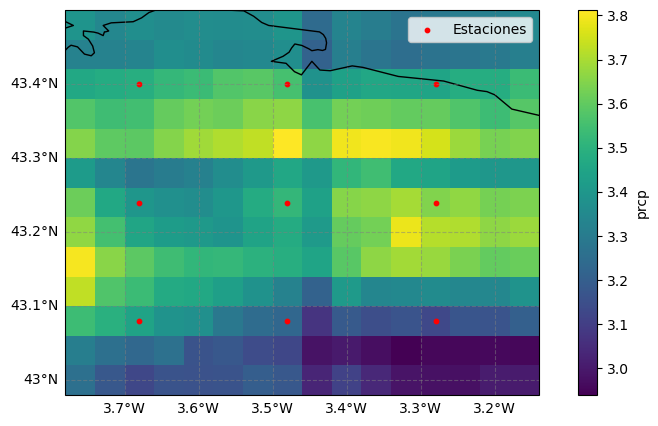

In [17]:
# Configurar el mapa usando Cartopy con ortofoto de OSM
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Añadir ortofoto de OpenStreetMap
osm_tiles = OSM()
ax.add_image(osm_tiles, 10)

# Añadir meridianos y paralelos
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Añadir línea de costa de alta definición
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1, edgecolor='black')

# Ploteo de los puntos
df_ZE.prcp.mean(dim='time').plot(ax=ax)
plt.scatter(Input_Attr_2['X'], Input_Attr_2['Y'], color='red', s=10,label='Estaciones')
plt.legend()

# Títulos y etiquetas
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el mapa
plt.show()

## Calibración utilizando las series de perssian extraidas en los puntos

In [18]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_SPD.yml')

# Input statistics calculated from several Rainfall series
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Series_2, attributes = Input_Attr_2)

In [ ]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, Input_Series_2, verbose=False)
os.makedirs('./POINT_SPATIAL_DAILY/CAL_PERSSIAN_2/',exist_ok=True)
CAL1.save_files('./POINT_SPATIAL_DAILY/CAL_PERSSIAN_2/') #save python objects

### Interpolamos las series reales

In [19]:
lon_grid, lat_grid = np.meshgrid(df_ZE.lon.data,df_ZE.lat.data)

In [20]:
calibrated_params = pd.read_csv('./POINT_SPATIAL_DAILY/CAL_PERSSIAN_2/Calibrated_parameters.csv',index_col=0)

X = Input_Attr_2[['X', 'Y']].values

calibrated_params_month = allmonths(calibrated_params.T)

lon_lat_vector = np.column_stack((lon_grid.ravel(),lat_grid.ravel()))

results = np.ones((len(Series_SPD_Perssian_2),lat_grid.shape[0],lat_grid.shape[1]))*np.nan
# Crear un diccionario para almacenar las predicciones
predicciones = {}

points = X

# Iterar sobre cada registro de la serie temporal
t=0
for index, row in tqdm.tqdm(Series_SPD_Perssian_2.iterrows()):
    if np.isnan(np.mean(row))==True:
        t = t+1
        continue
    else:
        # Obtener el mes del registro actual
        mes = index.month
        
        # Obtener los parámetros para el mes actual
        landa, mu_c, eta, betha, fi_may = calibrated_params_month.loc[mes, :]
        alpha = 1
        alpha_p = 1
        xi = 1
        
        # Extraer los datos de precipitación para el registro actual
        Y = row.values.reshape(-1, 1)

        # Crear una instancia del kernel personalizado con paralelización
        kernel = NSRP_CrossCorrelationKernel([landa], [mu_c], [eta], [xi], [betha], [alpha], [alpha_p], [fi_may])
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)
        # Ajustar el modelo a los datos
        values = Y
        gp.fit(points, values)
        y_pred, sigma_pred = gp.predict(lon_lat_vector, return_std=True)
        y_pred[y_pred<0] = 0
        results[t,:,:] = y_pred.reshape(lat_grid.shape)
        t = t+1

7867it [12:22, 10.59it/s]


## Kriging

In [21]:
best_params_by_season = fit_variogram_by_season(points,Series_SPD_Perssian_2)

[4.61655052 4.32204545 4.29332323 4.51643436 4.705899   4.93348484
 4.79901515 4.81019191 4.72069696]
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored f

2024-07-17 13:50:52,585 - INFO - Best parameters for Winter: {'method': 'universal', 'nlags': 10, 'variogram_model': 'linear', 'weight': True} with score 0.048939283745606556


n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2024-07-17 13:50:53,933 - INFO - Best parameters for Spring: {'method': 'universal', 'nlags': 6, 'variogram_model': 'spherical', 'weight': True} with score 0.01635456294337555


n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2024-07-17 13:50:55,070 - INFO - Best parameters for Summer: {'method': 'universal', 'nlags': 4, 'variogram_model': 'spherical', 'weight': True} with score 0.0052752223077371565


n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2024-07-17 13:50:56,565 - INFO - Best parameters for Autumn: {'method': 'universal', 'nlags': 4, 'variogram_model': 'linear', 'weight': True} with score 0.0909374112569538


n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

In [22]:
results_kriging = np.ones((len(Series_SPD_Perssian_2),lat_grid.shape[0],lat_grid.shape[1]))*np.nan
results_prob    = np.ones((len(Series_SPD_Perssian_2),lat_grid.shape[0],lat_grid.shape[1]))*np.nan

In [28]:
# Iterar sobre cada registro de la serie temporal
t=0
for index, row in tqdm.tqdm(Series_SPD_Perssian_2.iterrows()):
    month = pd.to_datetime(index).month
    season = None
    if month in [1, 2, 3]:
        season = 'Winter'
    elif month in [4, 5, 6]:
        season = 'Spring'
    elif month in [7, 8, 9]:
        season = 'Summer'
    elif month in [10, 11, 12]:
        season = 'Autumn'

    if season not in best_params_by_season:
        logger.warning(f"No best parameters for season {season}. Skipping day {index}.")
        continue
    
    best_params = best_params_by_season[season]

    # Obtener el mes del registro actual
    if np.max(row.values)==0:
        y_pred = lon_lat_vector[:,0].copy()*0
        y_pred = y_pred.reshape(lat_grid.shape)
    elif np.isnan(np.mean(row))==True:
        y_pred = lon_lat_vector[:,0].copy()*0
        y_pred = y_pred.reshape(lat_grid.shape)
        y_pred[:,:] = np.nan

    elif len(np.unique(row.values)) < 2:
        y_pred = lon_lat_vector[:,0].copy()*0
        y_pred = y_pred.reshape(lat_grid.shape)
        y_pred[:,:] = np.unique(row.values)
    else:
        OK = Krige(best_params['method'],
            variogram_model=best_params['variogram_model'],
            nlags=best_params['nlags'],
            weight=best_params['weight'],
            coordinates_type='geographic',
            verbose=False
        )
        OK.fit(np.column_stack((points[:,0], points[:,1])), row.values,verbose=False)
        
        y_pred = OK.predict(lon_lat_vector)
        y_pred = y_pred.reshape(lat_grid.shape)

        # IDW para probabilidad de lluvia
        indicator_values = (row.values > 0).astype(int)
        prob_pred = idw(points[:, 0], points[:, 1], indicator_values, lon_lat_vector[:, 0], lon_lat_vector[:, 1])
        prob_pred = prob_pred.ravel()
        prob_pred[prob_pred < 0] = 0
        prob_pred = prob_pred.reshape(lat_grid.shape)
        results_prob[t, :, :] = prob_pred

    y_pred[y_pred<0] = 0
    results_kriging[t,:,:] = y_pred
    t = t+1
    

29it [00:00, 281.55it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

91it [00:00, 271.92it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

119it [00:00, 210.92it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

196it [00:00, 236.29it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

225it [00:00, 248.11it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

288it [00:01, 266.31it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

344it [00:01, 259.32it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

405it [00:01, 249.58it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

472it [00:01, 288.32it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

531it [00:02, 272.27it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

587it [00:02, 271.00it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

648it [00:02, 278.35it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

744it [00:02, 360.90it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

810it [00:02, 431.09it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

855it [00:03, 333.60it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

939it [00:03, 318.92it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1015it [00:03, 329.92it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1096it [00:03, 342.62it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1152it [00:03, 399.61it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1233it [00:04, 292.33it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1266it [00:04, 264.36it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1324it [00:04, 237.57it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1350it [00:04, 217.35it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1396it [00:05, 204.52it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1423it [00:05, 219.39it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1486it [00:05, 265.44it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1549it [00:05, 278.41it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1578it [00:05, 232.07it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1626it [00:06, 191.10it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1650it [00:06, 202.29it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1763it [00:06, 313.41it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1820it [00:06, 383.25it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1901it [00:06, 369.02it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

1939it [00:07, 302.29it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2001it [00:07, 236.42it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2066it [00:07, 262.83it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2094it [00:07, 258.67it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2176it [00:07, 320.76it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2246it [00:08, 324.35it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2324it [00:08, 288.73it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2355it [00:08, 270.96it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2411it [00:08, 248.20it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2485it [00:09, 300.99it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2547it [00:09, 287.81it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2608it [00:09, 272.77it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2666it [00:09, 247.78it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2692it [00:09, 218.07it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2739it [00:10, 218.79it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2816it [00:10, 302.85it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2882it [00:10, 310.53it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

2944it [00:10, 281.86it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3005it [00:10, 287.79it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3063it [00:11, 262.12it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3129it [00:11, 290.06it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3193it [00:11, 291.33it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3236it [00:11, 326.41it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3365it [00:12, 394.54it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3405it [00:12, 340.29it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3441it [00:12, 267.84it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3505it [00:12, 274.05it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3563it [00:12, 268.38it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3622it [00:13, 273.66it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3678it [00:13, 262.29it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3733it [00:13, 263.14it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3760it [00:13, 215.01it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3814it [00:13, 237.44it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3877it [00:14, 256.22it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

3946it [00:14, 294.10it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4019it [00:14, 330.34it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4053it [00:14, 285.89it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4113it [00:14, 269.98it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4169it [00:15, 270.20it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4227it [00:15, 271.59it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4282it [00:15, 243.26it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4344it [00:15, 266.29it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4415it [00:16, 309.85it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4483it [00:16, 310.17it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4515it [00:16, 243.25it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4588it [00:16, 293.11it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4650it [00:16, 273.41it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4725it [00:17, 319.74it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4758it [00:17, 300.85it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4833it [00:17, 334.97it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4868it [00:17, 265.50it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

4924it [00:17, 228.04it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5010it [00:18, 306.84it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5082it [00:18, 328.30it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5130it [00:18, 370.70it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5205it [00:18, 347.08it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5276it [00:19, 267.84it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5306it [00:19, 258.31it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5421it [00:19, 341.16it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5476it [00:19, 396.57it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5518it [00:19, 336.79it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5588it [00:20, 254.93it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5622it [00:20, 271.26it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5679it [00:20, 233.98it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5779it [00:20, 341.75it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5863it [00:20, 342.40it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5900it [00:21, 333.17it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

5942it [00:21, 352.09it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


6009it [00:21, 253.73it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6039it [00:21, 236.28it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6101it [00:21, 252.37it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6160it [00:22, 264.70it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6225it [00:22, 288.37it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6287it [00:22, 293.88it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6317it [00:22, 251.97it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6344it [00:22, 193.84it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6405it [00:23, 241.06it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6504it [00:23, 286.60it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6564it [00:23, 282.63it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6597it [00:23, 292.66it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6674it [00:24, 302.78it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6706it [00:24, 259.73it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6759it [00:24, 213.87it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6815it [00:24, 290.72it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6881it [00:24, 278.95it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

6981it [00:25, 375.59it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7021it [00:25, 321.84it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7056it [00:25, 270.16it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7112it [00:25, 226.05it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7168it [00:25, 243.02it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7231it [00:26, 276.05it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7288it [00:26, 264.91it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7373it [00:26, 344.51it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7443it [00:26, 306.57it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7475it [00:27, 223.78it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7555it [00:27, 291.76it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7619it [00:27, 278.27it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7688it [00:27, 303.66it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7758it [00:27, 325.63it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7823it [00:28, 281.58it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7852it [00:28, 251.86it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

7867it [00:28, 276.54it/s]

n_closest_points will be ignored for UniversalKriging


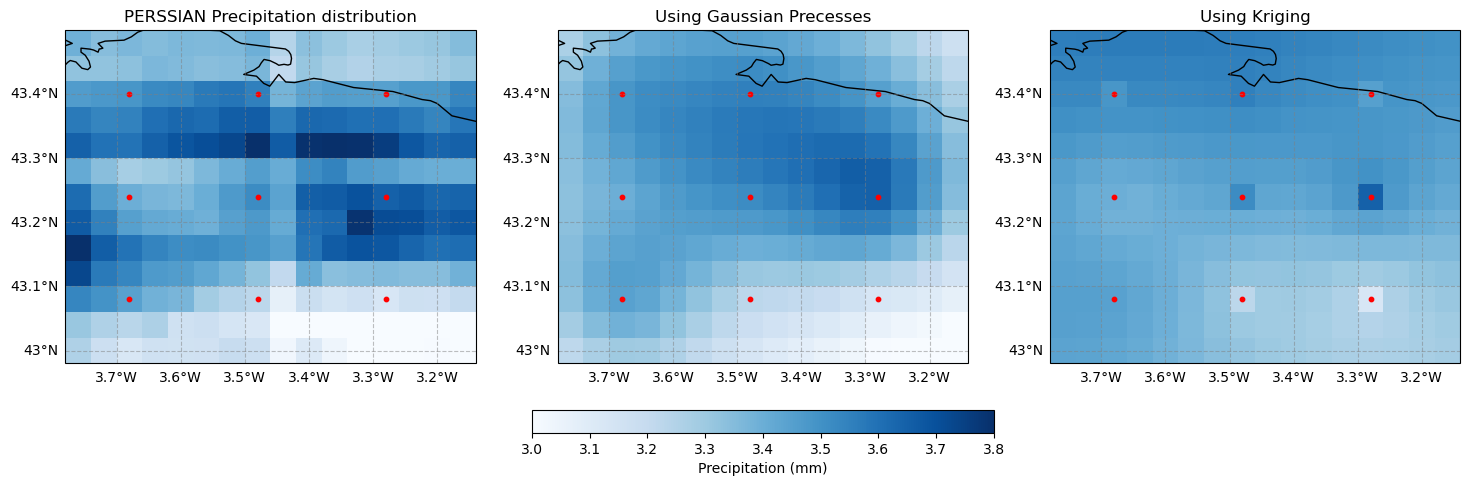

In [31]:
real = df_ZE.prcp.mean(dim='time').values

fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# Añadir ortofoto de OpenStreetMap a cada subplot
osm_tiles = OSM()
for ax in axes:
    ax.add_image(osm_tiles, 10)
    # Añadir meridianos y paralelos
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    # Añadir línea de costa de alta definición
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1, edgecolor='black')

im0 = axes[0].pcolormesh(lon_grid,lat_grid,real,cmap='Blues',shading='auto',vmin=3,vmax=3.8)
axes[0].set_title('PERSSIAN Precipitation distribution')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].scatter(Input_Attr_2['X'], Input_Attr_2['Y'], color='red', s=10,label='Estaciones')

axes[1].pcolormesh(lon_grid,lat_grid,np.nanmean(results,axis=0),cmap='Blues',shading='auto',vmin=3,vmax=3.8)
axes[1].set_title('Using Gaussian Precesses')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].scatter(Input_Attr_2['X'], Input_Attr_2['Y'], color='red', s=10,label='Estaciones')

axes[2].pcolormesh(lon_grid,lat_grid,np.nanmean(results_kriging,axis=0),cmap='Blues',shading='auto',vmin=3,vmax=3.8)
axes[2].set_title('Using Kriging')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
axes[2].scatter(Input_Attr_2['X'], Input_Attr_2['Y'], color='red', s=10,label='Estaciones')

# Añadir una única barra de color en la parte inferior
cbar = fig.colorbar(im0, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Precipitation (mm)')

array([[3.44427262, 3.22647219, 3.13045563],
       [3.39852569, 3.51862378, 3.64709511],
       [3.4852051 , 3.55465095, 3.4503673 ]])

In [35]:
real.shape

(13, 16)

In [37]:
mean_real = real[np.ix_([2,6,10],[2,7,12])]
mean_GP   = np.nanmean(results,axis=0)[np.ix_([2,6,10],[2,7,12])]
mean_KR   = np.nanmean(results_kriging,axis=0)[np.ix_([2,6,10],[2,7,12])]

In [38]:
mean_real

array([[3.44427262, 3.22647219, 3.13045563],
       [3.39852569, 3.51862378, 3.64709511],
       [3.4852051 , 3.55465095, 3.4503673 ]])

In [39]:
mean_GP

array([[3.44421456, 3.22650156, 3.1304776 ],
       [3.39854021, 3.51861902, 3.64701117],
       [3.48517083, 3.55463313, 3.45036896]])

In [40]:
mean_KR

array([[3.44427262, 3.22647219, 3.13045563],
       [3.39852569, 3.51862378, 3.64709511],
       [3.4852051 , 3.55465095, 3.4503673 ]])